# Research about sparse regression for vb by Latent vairable
## Background
+ In this study, we show how variable selection by latent variable gives a model selection.
    + Especially, we consider about linear regression case.
    
+ To update the result, we utilized a stochastic gradeient descent for vb

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import wishart, norm
from scipy.special import gammaln, digamma, logsumexp
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# problem settings

In [3]:
data_seed = 20210626
n = 40
M = 20

N = 100

In [4]:
true_p = 0.2

In [5]:
np.random.seed(data_seed)

In [6]:
true_w = np.random.normal(size=M, scale=3)
zero_ind = np.sort(np.random.dirichlet(np.ones(M), size=1).squeeze().argsort()[:np.floor(true_p * M).astype(int)])
true_w[zero_ind] = 0

In [7]:
# X_base = np.random.uniform(-1, 1, size=n)
# train_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
train_X = np.random.uniform(-1,1, size=(n, M))
train_Y = train_X@true_w + np.random.normal(scale=1, size=n)

In [8]:
# X_base = np.random.uniform(-1, 1, size=N)
# test_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
test_X = np.random.uniform(-1,1, size=(N, M))
test_Y = test_X@true_w + np.random.normal(scale=1, size=N)

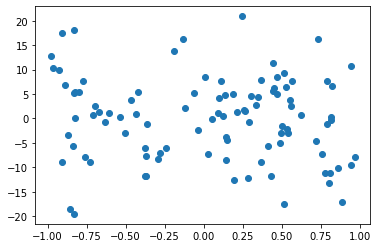

In [9]:
plt.scatter(test_X[:,1], test_Y)

# Learning part

## learning settings


In [10]:
pri_alpha = 1
pri_beta = 1
pri_gamma = 0.0001

iteration = 3000
rho = 1
learning_seed = 20210717

tol = 1e-5

step = 100

## initialization

In [11]:
np.random.seed(learning_seed)

## main learning

In [12]:
def calc_energy(
    train_X: np.ndarray, train_Y: np.ndarray,
    est_alpha: float, est_beta: float, est_mu: np.ndarray, est_sigma: np.ndarray, 
    est_h_xi: np.ndarray, est_z_xi: np.ndarray,
    pri_alpha: float, pri_beta: float, pri_gamma: float, pri_delta_c: float=0.001
):
    (n, M) = train_X.shape
    
    sum_alpha_beta = est_alpha+est_beta
    eta_p1 = digamma(est_alpha)-digamma(est_alpha+est_beta)
    eta_p2 = digamma(est_beta)-digamma(est_alpha+est_beta)
    eta_m2 = np.outer(est_mu, est_mu) + est_sigma
    
    current_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), pri_delta_c),
        eta_p2+log_normal_func(np.diag(eta_m2), 1/pri_gamma)
    ]).T
    
    KL_p = (est_alpha-1)*(eta_p1)+(est_beta-1)*(eta_p2)-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
    +gammaln(est_alpha+est_beta)-gammaln(est_alpha)-gammaln(est_beta)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)
    
    KL_m = -0.5*M-0.5*M*np.log(2*np.pi)+0.5*np.linalg.slogdet(est_sigma)[1]\
    - (logsumexp(est_h_xi).sum() + (est_z_xi * (current_h_xi - est_h_xi)).sum())
    
    loss_Y = 0.5*n*np.log(2*np.pi) + 0.5*((train_Y-train_X@est_mu)**2).sum() + 0.5*np.trace(train_X.T@train_X@est_sigma)
    
    return (KL_p+KL_m+loss_Y), KL_p, KL_m, loss_Y

In [13]:
def _transform_origin2natural(
    est_alpha: np.ndarray, est_beta: np.ndarray, est_mu: np.ndarray, est_sigma: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from original space to natural parameter space on exponential family
    
    + Output:
        1. theta_p1
        2. theta_p2
        3. theta_m1
        4. theta_m2
    """
    return (est_alpha-1, est_beta-1, np.linalg.solve(est_sigma, est_mu), -np.linalg.inv(est_sigma)/2)

def _transform_original2expectation(
    est_alpha: np.ndarray, est_beta: np.ndarray, est_mu: np.ndarray, est_sigma: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from natural parameter space to expectation parameter space on exponential family
    
    + Output:
        1. eta_p1: E[log p]
        2. eta_p2: E[log (1-p)]
        3. eta_m1: E[x]
        4. eta_m2: E[xx^T]
    """
    return(
        digamma(est_alpha) - digamma(est_alpha+est_beta), 
        digamma(est_beta) - digamma(est_alpha+est_beta),
        est_mu,
        est_sigma+np.outer(est_mu, est_mu)    
    )

def _transform_natural2origin(
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    transform parameter of posterior distribution from natural parameter space on exponential family to original space
    
    + Output:
        1. est_alpha
        2. est_beta
        3. est_mu
        4. est_sigma    
    """
    est_sigma = -0.5*np.linalg.inv(theta_m2)
    return(theta_p1+1, theta_p2+1, est_sigma@theta_m1, est_sigma)

In [14]:
def _calc_dFdeta(
    train_X: np.ndarray, train_Y: np.ndarray,
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray,
    est_z_xi: np.ndarray,
    pri_alpha: float, pri_beta: float, pri_gamma: float, pri_delta_c_t: float,
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Derivative of objective function F by expectation parameters
    
    + Output:
        1. Derivative of eta_p1
        2. Derivative of eta_p2
        3. Derivative of eta_m1
        4. Derivative of eta_m2
    """
    
    return (
        theta_p1 - est_z_xi[:,0].sum() - (pri_alpha - 1),
        theta_p2 - est_z_xi[:,1].sum() - (pri_beta - 1),
        theta_m1 - train_X.T@train_Y,
        theta_m2 + 0.5*train_X.T@train_X + (np.diag(est_z_xi[:,0]))/(2*pri_delta_c_t) + pri_gamma*(np.diag(est_z_xi[:,1]))/2,
    )

def _update_natural(
    theta_p1: np.ndarray, theta_p2: np.ndarray, theta_m1: np.ndarray, theta_m2: np.ndarray,
    dFdeta_p1: np.ndarray, dFdeta_p2: np.ndarray, dFdeta_m1: np.ndarray, dFdeta_m2: np.ndarray,
    rho_t: float
):
    return(
        theta_p1 - rho_t*dFdeta_p1,
        theta_p2 - rho_t*dFdeta_p2,
        theta_m1 - rho_t*dFdeta_m1,        
        theta_m2- rho_t*dFdeta_m2,
    )

In [15]:
def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))


def _negative_sigmoid(x):
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(x)
    return exp / (exp + 1)


def sigmoid(x):
    positive = x >= 0
    # Boolean array inversion is faster than another comparison
    negative = ~positive

    # empty contains juke hence will be faster to allocate than zeros
    result = np.empty_like(x)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])

    return result

In [26]:
est_alpha=np.random.gamma(shape=1, size=1).squeeze()
est_beta=np.random.gamma(shape=1, size=1).squeeze()
est_sigma = np.linalg.inv(wishart.rvs(df=M+1, scale=np.eye(M), size=1))
est_mu = np.random.normal(size=M)
est_lambda = np.random.uniform(size=M)

In [27]:
cov_X = train_X.T@train_X
cov_XY = train_Y@train_X

for ite in range(2):
    # transform to natural parameters
    theta_u1 = est_alpha-1
    theta_u2 = est_beta-1
    theta_z = np.log(est_lambda)-np.log(1-est_lambda)
    theta_w1 = np.linalg.solve(est_sigma, est_mu)
    theta_w2 = -np.linalg.inv(est_sigma)/2

    # tranform to expectation parameters
    eta_u1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
    eta_u2 = digamma(est_beta) - digamma(est_alpha+est_beta)
    eta_z = est_lambda
    eta_w1 = est_mu
    eta_w2 = np.outer(est_mu, est_mu)+est_sigma

    # derivate of expectation parameters
    dFdeta_u1 = theta_u1-eta_z.sum()-(pri_alpha-1)
    dFdeta_u2 = theta_u2-(1-eta_z).sum()-(pri_beta-1)
    dFdeta_z = theta_z\
    -(cov_XY*eta_w1)\
    +((cov_X-np.diag(np.diag(cov_X)))*eta_w2)@eta_z+np.diag(cov_X)*np.diag(eta_w2)/2\
    -eta_u1+eta_u2
    
    dFdeta_w1 = theta_w1-(cov_XY*eta_z)
    dLdeta_w2 = (cov_X*(np.outer(eta_z,eta_z)))/2
    dLdeta_w2[np.diag_indices(M)] = (np.diag(cov_X)*eta_z)/2
    dFdeta_w2 = theta_w2+dLdeta_w2+pri_gamma/2*np.eye(M)

    # update global parameters
    rho_t=rho/(ite+1)
    theta_u1 -= rho_t*dFdeta_u1
    theta_u2 -= rho_t*dFdeta_u2
    theta_z -= rho_t*dFdeta_z
    theta_w1 -= rho_t*dFdeta_w1
    theta_w2 -= rho_t*dFdeta_w2

    # transoform to original parameters
    est_alpha=theta_u1+1
    est_beta=theta_u2+1
    est_lambda=sigmoid(theta_z)
    est_sigma=-np.linalg.inv(theta_w2)/2
    est_mu=est_sigma@theta_w1


<ipython-input-27-ec7efaa948c1>:8: RuntimeWarning: divide by zero encountered in log
  theta_z = np.log(est_lambda)-np.log(1-est_lambda)
<ipython-input-27-ec7efaa948c1>:36: RuntimeWarning: invalid value encountered in subtract
  theta_z -= rho_t*dFdeta_z


In [28]:
est_lambda

array([2.96290530e-02, 9.99487850e-01, 4.49363410e-03, 1.20947918e-01,
       9.99999999e-01, 9.32302297e-01, 2.41740831e-03, 4.17482571e-12,
                  nan, 9.99999999e-01, 2.27953371e-21, 2.38342204e-02,
       6.01721585e-03, 9.99976778e-01, 3.02220593e-02,            nan,
                  nan, 2.02461458e-02, 9.99764438e-01, 1.71918571e-02])

In [25]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [109]:
est_lambda

array([1.96450585e-005, 1.00000000e+000, 4.71979152e-014, 2.46847029e-100,
       3.32730950e-196, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 7.89555422e-043,
       0.00000000e+000, 1.83273117e-143, 1.00000000e+000, 0.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000])

In [110]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [98]:
cov_XY*est_lambda

array([-7.08143775e-004,  9.84498726e+000,  4.80847874e-002,
        1.45377486e-008,  1.69388070e-021,  4.15320035e+000,
       -4.52954491e+001, -4.53838723e-143,  1.11081597e+002,
       -3.45411439e+001,  8.13846650e-043,  7.86345510e+000,
       -1.39753768e-042, -4.26693731e-023,  1.59344587e-010,
        0.00000000e+000, -7.71328864e-014,  2.20157973e+001,
       -2.48983696e-006, -2.83266062e-003])

In [96]:
est_mu

array([ 1.69552008, -0.65854669, -0.42952954, -1.0774449 ,  4.1498615 ,
       -8.17738478, 42.44484559,  0.70292475, 39.41550626, -1.25972328,
        5.42451832, -0.93631788,  6.87155991,  0.99892469, -0.28441021,
        6.16094379, -6.34262639,  2.70006912, -0.20343477, -1.28479332])

In [95]:
est_lambda

array([2.48668865e-004, 1.00000000e+000, 2.59013540e-003, 1.30426592e-007,
       1.59351923e-022, 9.99772344e-001, 1.00000000e+000, 3.38775478e-143,
       1.00000000e+000, 1.00000000e+000, 1.91467667e-044, 9.99418297e-001,
       7.08845057e-043, 1.37128862e-024, 6.28602510e-011, 0.00000000e+000,
       7.04883494e-016, 1.00000000e+000, 6.09693924e-008, 4.60124158e-004])

In [91]:
est_mu

array([ 0.25719579, -1.05155803,  0.37975845, -0.46125126,  2.7094475 ,
       -3.972607  , -1.53000991,  1.48171971,  6.95595953, -2.48631588,
        1.92105896, -2.48982835,  1.83804827, -1.40105849, -0.50529227,
        5.23666238, -5.98856215,  1.13941316, -1.87528804, -1.11479319])

In [90]:
est_lambda

array([            nan, 8.62677207e-104, 4.58282228e-013, 6.89182947e-009,
                   nan, 1.00000000e+000, 9.51875128e-056, 9.99266916e-001,
                   nan,             nan, 9.94822653e-001, 1.30866381e-029,
                   nan, 5.27277330e-001, 1.60712976e-002,             nan,
                   nan,             nan, 3.53310198e-025, 9.99943642e-001])

In [84]:
est_lambda

array([4.33000978e-014, 1.00000000e+000, 5.45698613e-026, 1.88045199e-040,
                   nan,             nan, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 9.99999999e-001, 1.00000000e+000, 1.14090553e-002,
                   nan, 9.28565372e-002, 5.23525804e-074,             nan,
                   nan, 1.00000000e+000, 2.98379236e-193, 9.99999891e-001])

In [83]:
theta_z

array([-3.07706215e+01,  7.80043061e+03, -5.81703158e+01, -9.14718916e+01,
                   nan,             nan,  1.18696098e+02,  1.16532193e+02,
        1.94420006e+03,  2.10929222e+01,  3.97520323e+02, -4.46187327e+00,
                   nan, -2.27924492e+00, -1.68735881e+02,             nan,
                   nan,  1.62237255e+02, -4.43305728e+02,  1.60324678e+01])

In [79]:
est_lambda

array([1.40345259e-009, 2.58143273e-141, 7.15966691e-004, 2.87349602e-010,
       9.99999804e-001, 2.64322049e-025, 1.62411071e-071, 1.56802792e-002,
       1.00000000e+000, 1.00000000e+000, 6.75112029e-001, 3.83373943e-010,
       1.00000000e+000, 9.13629671e-006, 9.12845032e-002, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 9.87575283e-006, 4.42980753e-010])

In [80]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [69]:
0.99999999999999999

1.0

In [70]:
est_lambda > 0.99999999

array([ True,  True, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True])

In [67]:
np.log(est_lambda) - np.log(1-est_lambda)

<ipython-input-67-98a1760dc2ca>:1: RuntimeWarning: divide by zero encountered in log
  np.log(est_lambda) - np.log(1-est_lambda)


array([            inf,             inf,  5.74286582e-01,             inf,
                   inf,             inf,             inf,             inf,
                  -inf, -3.61675602e+02, -5.99748413e+02,             inf,
                   inf,             inf,            -inf,            -inf,
                  -inf,            -inf, -1.83047858e+02,             inf])

In [66]:
est_lambda

array([1.00000000e+000, 1.00000000e+000, 6.39751692e-001, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       0.00000000e+000, 8.43882285e-158, 3.40858209e-261, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 3.18658491e-080, 1.00000000e+000])

In [55]:
est_lambda

array([3.17667119e-01, 9.72213491e-01, 1.56140468e-02, 8.67006579e-02,
       9.53652693e-01, 5.93756939e-02, 1.33389839e-12, 3.75962037e-01,
       1.83017078e-20, 9.99996357e-01, 9.72740787e-03, 5.43371384e-01,
       9.42244627e-01, 5.28195218e-02, 5.78842300e-04, 1.00891537e-05,
       2.56965188e-06, 4.93603292e-03, 9.98986806e-01, 2.97959817e-01])

In [47]:
est_lambda

array([3.66962727e-015, 0.00000000e+000, 2.81471982e-001, 5.69725167e-023,
       3.34098629e-003, 1.00000000e+000, 1.94949602e-070, 1.00000000e+000,
       1.00000000e+000, 4.27952034e-048, 1.00000000e+000, 9.14006972e-140,
       0.00000000e+000, 5.37533681e-005, 9.03212161e-001, 1.00000000e+000,
       1.00000000e+000, 6.73997602e-013, 1.00000000e+000, 1.00000000e+000])

In [48]:
true_w

array([ 0.4294891 , -1.40978187,  0.        ,  0.        ,  2.76727267,
       -2.32893547,  2.36452661,  1.02587881,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698,  0.        ,  0.        ,
        6.12070258, -4.54728625,  1.80098301,  1.25293761, -0.50114129])

In [41]:
np.exp(-theta_z)

<ipython-input-41-17adcc444ab1>:1: RuntimeWarning: overflow encountered in exp
  np.exp(-theta_z)


array([1.77897354e-079, 1.50286082e-012, 2.20738383e+000, 1.80390204e+004,
       1.32663492e-206, 3.08765370e-063, 5.58526474e-023, 5.50708612e+011,
       3.20215635e+005, 7.49385816e+063, 7.23090447e-047, 1.69020221e-067,
       4.29737691e-045, 2.83203115e+000, 1.49791656e+002, 1.11251632e-023,
                   inf, 1.26533038e-146, 1.69375595e-001, 6.13233748e+001])

In [42]:
theta_z

array([ 1.81328186e+02,  2.72236506e+01, -7.91808027e-01, -9.80029249e+00,
        4.74049884e+02,  1.43935449e+02,  5.12393253e+01, -2.70344717e+01,
       -1.26767499e+01, -1.47076945e+02,  1.06243135e+02,  1.53748353e+02,
        1.02158324e+02, -1.04099417e+00, -5.00924537e+00,  5.28528327e+01,
       -5.40245965e+03,  3.35942090e+02,  1.77563658e+00, -4.11616109e+00])

In [18]:
est_lambda

array([1.64957717e-15, 1.02791913e-10, 8.65457726e-26, 2.40563879e-05,
       1.74474234e-04, 1.37821118e-08, 5.43638662e-14, 1.80786725e-07,
       1.30013326e-11, 4.73817485e-01, 1.00000000e+00, 1.41088771e-06,
       1.63398420e-05, 1.12984159e-04, 1.50438285e-03, 1.49005398e-68,
       1.00000000e+00, 3.93116530e-04, 4.05900251e-17, 3.89023533e-03])

In [50]:
est_lambda

array([1.02763547e-08, 1.65228836e+06, 1.81424770e-06, 2.78827251e-15,
       3.31815472e+10, 3.05154144e+04, 5.53016714e-10, 1.62171003e-11,
       8.06152453e-21, 2.98526038e-16, 1.62360111e-02, 3.24591455e-03,
       1.15556810e+04, 1.07917941e-06, 7.58873142e-23, 1.47375531e-12,
       5.45301475e-23, 1.79086965e-04, 5.67489747e-02, 1.69648664e+00])

In [38]:
est_lambda

array([9.69423471e+01, 5.36416210e-25, 1.89432084e-02, 3.04318140e-12,
       2.72564934e+29, 2.87273751e-09, 1.98610367e+13, 6.74897050e-02,
       1.19973507e-13, 1.32483391e+08, 5.28573587e-01, 5.62988557e-04,
       2.21079077e+01, 1.59263361e-06, 2.40275278e-19, 8.50109476e+17,
       8.44924323e-26, 5.14941913e-04, 6.57062297e-03, 4.58069179e+01])

In [18]:
# prev_energy = np.inf
pri_delta_c_t = pri_delta_c
for ite in range(iteration):   
    ### transform to natural parameters
    (theta_p1, theta_p2, theta_m1, theta_m2) = _transform_origin2natural(est_alpha, est_beta, est_mu, est_sigma)
    
    ### set expectation parameters
    (eta_p1, eta_p2, eta_m1, eta_m2) = _transform_original2expectation(est_alpha, est_beta, est_mu, est_sigma)
    
    ### update local parameter
    est_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), sigma=pri_delta_c_t),
        eta_p2+log_normal_func(np.diag(eta_m2), sigma=1/pri_gamma),
    ]).T

    est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

    ### derivative of expectation parameters
    (dFdeta_p1, dFdeta_p2, dFdeta_m1, dFdeta_m2) = _calc_dFdeta(
        train_X, train_Y,
        theta_p1, theta_p2, theta_m1, theta_m2,
        est_z_xi,
        pri_alpha, pri_beta, pri_gamma, pri_delta_c_t,
    )
    
    ### update global parameters
    (theta_p1, theta_p2, theta_m1, theta_m2) = _update_natural(
        theta_p1, theta_p2, theta_m1, theta_m2, 
        dFdeta_p1, dFdeta_p2, dFdeta_m1, dFdeta_m2,
        rho_t=rho/(ite+1)
    )
    
    ### transform to original parameters
    (est_alpha, est_beta, est_mu, est_sigma) = _transform_natural2origin(theta_p1, theta_p2, theta_m1, theta_m2)

    pri_delta_c_t = pri_delta_c/(ite+1)
#     pri_delta_c_t = pri_delta_c
#     pri_delta_c_t = (est_z_xi[:,0]*np.diag(eta_m2)).sum() / (est_z_xi[:,0].sum()+100)
    
    
    energy = calc_energy(
            train_X, train_Y,
            est_alpha, est_beta, est_mu, est_sigma,
            est_h_xi, est_z_xi,
            pri_alpha, pri_beta, pri_gamma, pri_delta_c_t
    )[0]
    
    print(energy, dFdeta_p1, dFdeta_p2, (dFdeta_m1**2).sum(), (dFdeta_m2**2).sum())
    print((est_z_xi[:,0]*np.diag(eta_m2)).sum() / (est_z_xi[:,0].sum()))
    
#     if ite%step == 0:
#         print(energy, dFdeta_p1, dFdeta_p2, (dFdeta_m1**2).sum(), (dFdeta_m2**2).sum())
# #     print("delta variance: ", (est_z_xi[:,0]*np.diag(eta_m2)).sum() / est_z_xi[:,0].sum())

#     if np.abs(energy - prev_energy) < tol:
#         break
#     else:
#         prev_energy = energy
    pass

-485.52294172994897 -42.36740305866777 -153.41825087062097 23087891.53702127 3402632.7867648695
0.5873611849144432
-301.9286842296467 -14.943826755419359 14.943826755419366 2.6589494189775606e-15 993.4357288284976
0.13327145064080567
-286.0184906623538 -7.467005637422318 7.467005637422318 4.0777939466615545e-15 7485.032323249236
0.06154437635301078
-286.5471960266457 -4.993195066008994 4.99319506600898 6.405593564180918e-15 17645.899622544115
0.041321993231473036
-290.60072489511725 -4.0360893176353585 4.036089317635373 7.974925119760937e-15 30835.29467687858
0.03180301219973944
-292.69458974451413 -3.836350363605092 3.836350363605078 8.00150724860104e-15 48515.10534530013
0.02488917267970507
-291.6298391884957 -3.1978521031221945 3.197852103122216 8.885158526723718e-15 67362.69104963896
0.019469106115748754
-292.75591672098966 -2.7410967671846436 2.741096767184615 1.9529239003952646e-14 89121.31190776368
0.01628887562557441
-294.1000642442352 -2.398510995406781 2.398510995406781 2.153

In [19]:
est_alpha/(est_alpha+est_beta)

0.29204752097938663

In [20]:
est_z_xi.sum(axis=0)

array([ 57.99999936, 142.00000064])

In [21]:
(est_z_xi.argmax(axis=1)==1).sum()

142

In [28]:
est_z_xi

array([[9.99999989e-01, 1.10447150e-08],
       [9.99999989e-01, 1.10447153e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447152e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447131e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447137e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447134e-08],
       [0.00000000e+00, 1.00000000e+00],
       [9.99999989e-01, 1.10447131e-08],
       [9.99999989e-01, 1.10447152e-08],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.000000

In [35]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [34]:
(est_z_xi.argmax(axis=1) == 1).astype(int) * est_mu

array([-0.        , -0.        , -0.77150164,  0.        ,  2.19986909,
        1.63656997,  7.48953744,  0.        ,  1.78802511,  0.        ,
        1.53637403, -5.66963947, -0.        , -2.00466498, -0.        ,
       -0.        , -3.08650045,  5.79000116, -6.86392225, -4.48907671,
       -1.45153858, -9.71454422,  4.50990693, -0.60816915,  4.56944151,
       -0.        ,  3.25124637,  3.11948328,  4.08083882, -3.69999586,
       -3.97515787, -0.        , -0.        , -0.        ,  7.57265538,
        5.13075004, -1.68740658, -1.37186902, -0.73920284,  0.22035656,
       -1.31120983, -0.        , -0.        , -0.        , -2.12457931,
        7.06295997,  3.39179667, -4.46901816, -0.        , -4.75809822,
       -6.37062859, -3.40772088,  2.95234927, -0.26489946, -1.88013911,
       -0.22321462,  0.58515121,  2.42119776,  0.        ,  1.82775106,
       -2.46293766,  0.        ,  0.        ,  3.80945815, -5.85131518,
        5.10339301, -9.34776084, -2.45262764, -8.86879685, -1.68

In [ ]:
est_mu

In [27]:
est_mu

array([-5.78293827e-09, -3.06617510e-10, -7.71501643e-01,  6.24358393e-09,
        2.19986909e+00,  1.63656997e+00,  7.48953744e+00,  1.07953658e-08,
        1.78802511e+00,  4.01599904e-09,  1.53637403e+00, -5.66963947e+00,
       -4.44338761e-10, -2.00466498e+00, -7.04678187e-09, -1.58151889e-08,
       -3.08650045e+00,  5.79000116e+00, -6.86392225e+00, -4.48907671e+00,
       -1.45153858e+00, -9.71454422e+00,  4.50990693e+00, -6.08169151e-01,
        4.56944151e+00, -1.05856823e-07,  3.25124637e+00,  3.11948328e+00,
        4.08083882e+00, -3.69999586e+00, -3.97515787e+00, -3.99600185e-08,
       -2.40631820e-08, -1.58427097e-08,  7.57265538e+00,  5.13075004e+00,
       -1.68740658e+00, -1.37186902e+00, -7.39202837e-01,  2.20356563e-01,
       -1.31120983e+00, -5.12544037e-08, -8.82287992e-08, -3.48952232e-08,
       -2.12457931e+00,  7.06295997e+00,  3.39179667e+00, -4.46901816e+00,
       -5.52904264e-08, -4.75809822e+00, -6.37062859e+00, -3.40772088e+00,
        2.95234927e+00, -

In [25]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [24]:
(np.abs(true_w) > 0).sum()

160

In [23]:
true_w

array([ 0.4294891 , -1.40978187, -2.84652443,  5.09072289,  2.76727267,
       -2.32893547,  2.36452661,  0.        ,  9.13841238, -3.65001565,
        1.87929357, -0.77970708,  4.14196698, -3.16340453,  1.04157394,
        6.12070258,  0.        ,  1.80098301,  1.25293761, -0.50114129,
       -0.36065756, -6.0292734 , -1.94586965, -0.95279392,  6.40924052,
       -7.99746874,  6.10961841, -1.02320217,  0.        ,  2.2902942 ,
       -3.77067538,  0.        ,  0.        , -0.34270883,  7.48580323,
        1.73709206, -1.39259302, -9.59472893,  3.97642022,  3.26153344,
        0.        ,  2.08410259,  0.        , -3.10226697, -2.65354347,
        1.36337223,  2.8464958 , -1.64682997, -1.06526825, -2.92123115,
       -2.23117948,  1.47115227,  0.54705583, -1.28262698, -2.12500214,
       -1.14323844,  3.56325569,  1.23902351,  1.97769386,  0.80848478,
       -3.3005887 ,  0.        ,  2.8132868 ,  4.10957732, -3.62366988,
       -2.07222035, -1.46284763, -4.59360551, -3.18941287,  0.  

In [24]:
est_mu

array([ 2.60096882e-08, -6.25108356e-09, -3.42223264e+00, -1.98723348e-08,
        2.08028446e-01,  2.74620303e+00,  4.39605904e+00,  1.51048603e-08,
        2.36319360e+00, -3.95522059e-08, -2.84092338e+00, -1.09782140e-01,
        2.56971855e-08,  2.62034655e+00, -1.01421654e-08,  5.60262365e-08,
       -2.12039872e+00,  1.80100369e+00, -1.30230481e+00, -4.13989150e+00,
       -6.19238107e-02, -5.74921682e-01,  1.21406961e+00, -2.80856417e+00,
        6.52866373e-01, -5.58298840e-08,  4.89024308e+00,  9.92118224e-01,
        1.15737433e+00, -1.04319945e-01, -4.52935519e+00, -4.13765952e-08,
       -6.01885098e-08,  1.89192537e-08,  8.05082222e-01, -8.87741958e-01,
       -2.96033409e-02, -2.36229032e+00, -1.29237623e+00, -4.65365607e-01,
       -1.87608821e+00, -1.54942951e-09, -5.49139715e-08,  2.73921114e-08,
       -5.73528936e-01,  2.72790011e+00, -7.69323836e-01, -1.85163912e-01,
        1.73715774e-08,  6.68043500e-01, -5.59512550e+00, -9.10338232e-01,
        2.13170239e+00,  

In [41]:
zero_ind

array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  32,  33,
        34,  35,  37,  38,  40,  41,  42,  43,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  62,  67,  68,  70,  71,
        72,  74,  75,  76,  77,  80,  81,  82,  83,  84,  86,  87,  88,
        90,  92,  93,  94,  96,  97,  98, 100, 101, 103, 104, 105, 106,
       107, 109, 110, 111, 112, 114, 117, 118, 119, 120, 121, 123, 125,
       128, 129, 130, 131, 134, 135, 136, 137, 138, 142, 143, 144, 145,
       148, 150, 152, 153, 154, 155, 156, 159, 160, 161, 162, 163, 164,
       165, 166, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180,
       182, 183, 184, 186, 187, 188, 189, 192, 193, 194, 195, 196, 198,
       200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 213, 216, 217,
       218, 219, 220, 221, 222, 225, 226, 227, 230, 231, 232, 234, 235,
       236, 238, 240, 242, 244, 245, 247, 248, 250, 251, 252, 25

In [36]:
np.where(est_z_xi.argmax(axis=1)==0)[0]

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 37, 39],
      dtype=int64)

In [47]:
true_w[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -3.61173583, -1.30717887,  0.        ,
        0.        ,  0.        ,  0.        ,  3.65335021,  2.95643311,
        0.        ,  0.        ,  0.25756714,  0.        ,  0.        ])

In [48]:
est_mu[:20]

array([ 6.69445275e-04,  1.83223307e-04, -3.27882897e-03,  1.74784028e-03,
        3.97219922e-04,  1.27771536e-03,  1.27015832e-03, -3.47879626e+00,
       -4.48258742e+00, -1.09697037e-04,  3.28883088e-03,  1.28584447e-03,
        5.01862934e-04,  3.04200209e+00, -6.60284994e-04,  9.54805275e-04,
       -1.09213967e-03,  8.39790653e-04,  2.83315383e-03, -4.07107087e+00])

In [36]:
clf = LassoCV(fit_intercept=False, max_iter=2000)
clf.fit(train_X, train_Y)

LassoCV(fit_intercept=False, max_iter=2000)

In [42]:
((true_w - est_w)**2).mean()

9.676963614046727

In [43]:
((true_w - clf.coef_)**2).mean()

4.85858829838596

In [40]:
est_w = est_mu
est_w[np.where(est_z_xi.argmax(axis=1) == 0)[0]] = 0

In [41]:
print(
    np.sqrt(((test_Y - test_X@true_w)**2).mean()),
    np.sqrt(((test_Y - test_X@est_w)**2).mean()),
    np.sqrt(((test_Y - test_X@clf.coef_)**2).mean()),    
)

0.0989161823180474 25.211331450877616 15.88351319972445


In [28]:
# ### transform to natural parameters
# theta_p1 = est_alpha-1
# theta_p2 = est_beta-1
# theta_m1 = np.linalg.solve(est_sigma, est_mu)
# theta_m2 = -np.linalg.inv(est_sigma)/2

# ### set expectation parameters
# eta_p1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
# eta_p2 = digamma(est_beta) - digamma(est_alpha+est_beta)
# eta_m1 = est_mu
# eta_m2 = est_sigma + np.outer(est_mu, est_mu)

# ### update local parameter
# est_h_xi = np.vstack([
#     eta_p1+approx_delta_log_func(np.diag(eta_m2)),
#     eta_p2+norm.logpdf(np.diag(eta_m2), loc=0, scale=1/pri_beta**2)
# ]).T

# est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

# ### derivative of expectation parameters
# n_z = est_z_xi.sum(axis=0)
# dFdeta_p1 = theta_p1 - n_z[0] - (pri_alpha - 1)
# dFdeta_p2 = theta_p2 - n_z[1] - (pri_alpha - 1)
# dFdeta_m1 = theta_m1 - train_X.T@train_Y
# dFdeta_m2 = theta_m2 + 0.5*train_X.T@train_X + n_z[0]/(2*pri_delta_c) + n_z[1]/2*pri_gamma

# ### update global parameters
# rho_t=rho/(ite+1)
# theta_p1 -= rho_t*dFdeta_p1
# theta_p2 -= rho_t*dFdeta_p2
# theta_m1 -= rho_t*dFdeta_m1
# theta_m2 -= rho_t*dFdeta_m2

# ### transform to original parameters
# est_alpha = theta_p1 + 1
# est_beta = theta_p2 + 1
# est_sigma = -0.5*np.linalg.inv(theta_m2)
# est_mu = est_sigma @ theta_m1

In [ ]:
# calc_energy(
#     train_X, train_Y,
#     est_alpha, est_beta, est_mu, est_sigma,
#     est_h_xi,
#     pri_alpha, pri_beta, pri_gamma
# )

# np.trace(k)

# np.linalg.slogdet(est_sigma)[1]

# theta_p1*eta_p1+theta_p2*eta_p2-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
# +gammaln(theta_p1+theta_p2+2)-gammaln(theta_p1+1)-gammaln(theta_p2+1)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)

# -logsumexp(est_h_xi, axis=1).sum()

# train_X @ est_mu

# train_Y@train_Y/2

# train_Y @ train_X @ est_mu

# train_X.T @ train_X @ est_sigma

# ((train_Y - train_X @ est_mu)**2).sum()/2 + 